In [1]:
import logging

import numpy as np
import xgboost as xgb
import talib
from binance.enums import HistoricalKlinesType
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from main_funcs import get_and_update_data

In [2]:
# configs
country=None
joft = "ETHUSDT"
interval = "4h"

# remove small candle 
zero_remover_pct = 0.0

# add history of open_close_pct 
open_close_pct_history_count = 40

# add history of max_low_high_pct 
max_low_high_pct_history_count = 40

# calculate rsi with different lengths 
rsi_ranges = range(14, 14)

# add history of rsi
rsi_history_count = 60

# add moving average of rsi
rsi_ma_lengths = [3,7,9,10,14,20,50,100]
rsi_ma_ranges = []


In [3]:
# validation config

# valid rsi_ma_ranges
for r in  rsi_ma_ranges:
    if not r in rsi_ranges:
        raise ValueError("rsi_ma_ranges items is not in rsi_ranges")

In [4]:
# get data from database
df_source = get_and_update_data(joft, interval, HistoricalKlinesType.SPOT, country=country)
df_source = df_source[["open", "high", "low", "close", "volume"]]
# df_source.tail(1)

In [5]:
# calculate parameters
df_cal = df_source.copy()

# change from open to other columns
df_cal['open_close'] = df_cal.close - df_cal.open
df_cal['open_low'] = df_cal.low - df_cal.open
df_cal['open_high'] = df_cal.high - df_cal.open

# change percent from open to other columns
df_cal['open_close_pct'] = df_cal.open_close / df_cal.open
df_cal['open_low_pct'] = df_cal.open_low / df_cal.open
df_cal['open_high_pct'] = df_cal.open_high / df_cal.open

# price direction
# df_target['open_close_direction'] = np.sign(df_target["open_close"])
# df_target['open_open_high_direction'] = np.sign(df_target["open_low"]).astype(int)
# df_target['open_high_direction'] = np.sign(df_target["open_high"]).astype(int)

# max abs low and high
df_cal['max_low_high_pct'] = np.where(
    df_cal['open_low_pct'].abs() > df_cal['open_high_pct'].abs(),
    df_cal['open_low_pct'],
    df_cal['open_high_pct']
)

# open_close_pct history
for h in range(0,open_close_pct_history_count+1):
    df_cal[f"open_close_pct__{h}"] = df_cal.open_close_pct.shift(h)
    

# max_low_high_pct history
for h in range(0,max_low_high_pct_history_count+1):
    df_cal[f"max_low_high_pct__{h}"] = df_cal.max_low_high_pct.shift(h)
    

# calculate multi rsi
for rsi in rsi_ranges:
    for h in range(0, rsi_history_count + 1):
        df_cal[f"rsi_{rsi}__{h}"] = talib.RSI(df_cal.close.shift(h), timeperiod=rsi)
        
# calculate rsi sma 
for ma_length in rsi_ma_lengths:
    for rsi in rsi_ma_ranges:
        df_cal[f"rsi_{rsi}_ma_{ma_length}"] =  talib.SMA(df_cal[f"rsi_{rsi}__{0}"], timeperiod=ma_length)
# df_cal

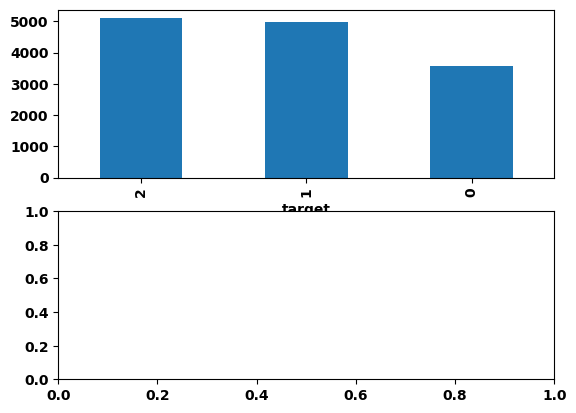

In [6]:
# create calculate target
df_target = df_cal.copy()

# calculate target
df_target["target"] = np.where(
    df_target['max_low_high_pct'] > zero_remover_pct,
    1,
    np.where(
        df_target['max_low_high_pct'] < -zero_remover_pct,
        -1, 0
    )
)

# convert -1 and 1 and 0 to True False for better result
df_target["target"] = np.where(df_target['target'] ==1, 1,0)


# show chart
fig, axs = plt.subplots(2, 1)
df_target["target"].value_counts().plot(kind='bar', ax=axs[0])
# (np.sign(df_target["open_close"]) == np.sign(df_target["target"])).value_counts().plot(kind='bar',ax=axs[1])

# shift target the real place
df_target["target"] = df_target["target"].shift(-1)
# df_target

In [7]:
# clean data
df = df_target.copy()
df.dropna(inplace=True)
df.drop(columns=['open', 'high', 'low', 'close', 'volume', 'open_close', 'open_low', 'open_high',
                 'open_close_pct', 'open_low_pct', 'open_high_pct', 'max_low_high_pct'], inplace=True)
df

,open_close_pct__0,open_close_pct__1,open_close_pct__2,open_close_pct__3,open_close_pct__4,open_close_pct__5,open_close_pct__6,open_close_pct__7,open_close_pct__8,open_close_pct__9,...,max_low_high_pct__32,max_low_high_pct__33,max_low_high_pct__34,max_low_high_pct__35,max_low_high_pct__36,max_low_high_pct__37,max_low_high_pct__38,max_low_high_pct__39,max_low_high_pct__40,target
open_time,,,,,,,,,,,,,,,,,,,,,
2017-08-23 23:30:00,-0.008883,0.002202,0.000000,0.000439,0.011444,0.016045,0.009022,0.006392,-0.008902,0.025570,...,-0.037234,0.018123,0.026841,-0.022550,0.030670,-0.030968,-0.017446,0.013151,0.022681,0.0
2017-08-24 03:30:00,-0.001647,-0.008883,0.002202,0.000000,0.000439,0.011444,0.016045,0.009022,0.006392,-0.008902,...,-0.038253,-0.037234,0.018123,0.026841,-0.022550,0.030670,-0.030968,-0.017446,0.013151,1.0
2017-08-24 07:30:00,0.010532,-0.001647,-0.008883,0.002202,0.000000,0.000439,0.011444,0.016045,0.009022,0.006392,...,-0.038990,-0.038253,-0.037234,0.018123,0.026841,-0.022550,0.030670,-0.030968,-0.017446,1.0
2017-08-24 11:30:00,0.015916,0.010532,-0.001647,-0.008883,0.002202,0.000000,0.000439,0.011444,0.016045,0.009022,...,0.022263,-0.038990,-0.038253,-0.037234,0.018123,0.026841,-0.022550,0.030670,-0.030968,1.0
2017-08-24 15:30:00,-0.004062,0.015916,0.010532,-0.001647,-0.008883,0.002202,0.000000,0.000439,0.011444,0.016045,...,-0.026061,0.022263,-0.038990,-0.038253,-0.037234,0.018123,0.026841,-0.022550,0.030670,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-12 19:30:00,-0.003889,0.004689,-0.004962,0.003086,-0.000847,-0.010878,0.003748,0.005098,0.001251,0.004124,...,-0.013130,0.003391,-0.012073,-0.010522,-0.008310,0.008169,0.010988,-0.009919,-0.005947,0.0
2023-11-12 23:30:00,-0.002162,-0.003889,0.004689,-0.004962,0.003086,-0.000847,-0.010878,0.003748,0.005098,0.001251,...,-0.008220,-0.013130,0.003391,-0.012073,-0.010522,-0.008310,0.008169,0.010988,-0.009919,1.0
2023-11-13 03:30:00,-0.002421,-0.002162,-0.003889,0.004689,-0.004962,0.003086,-0.000847,-0.010878,0.003748,0.005098,...,0.019811,-0.008220,-0.013130,0.003391,-0.012073,-0.010522,-0.008310,0.008169,0.010988,0.0


In [8]:
# analyse df
print("shape df: ", df.shape)
df.corr()['target'].sort_values(ascending=False)

shape df:  (13620, 83)


target                 1.000000
open_close_pct__5      0.030030
open_close_pct__18     0.020474
max_low_high_pct__5    0.019666
open_close_pct__27     0.011648
                         ...   
max_low_high_pct__9   -0.025197
max_low_high_pct__0   -0.025817
max_low_high_pct__1   -0.028672
max_low_high_pct__2   -0.030319
max_low_high_pct__3   -0.034762
Name: target, Length: 83, dtype: float64

In [9]:
# create cross validator
# Data and targets
X, Y = df.iloc[:, :-1], df.iloc[:, -1]

In [10]:
# random x and y train and test
# x_train, x_test, y_train, y_test= train_test_split(
#     X, Y, test_size=.15, random_state=123
# )
# test faghat akharin vaziyat va na besorat random
test_point = int(len(X)*0.85)
x_train, x_test, y_train, y_test = X.iloc[:test_point,:],X.iloc[test_point:,:],Y.iloc[:test_point],Y.iloc[test_point:]
le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_train
xgb_clf = xgb.XGBClassifier(random_state=123)
xgb_clf.set_params(n_estimators=500)
xgb_clf.fit(x_train, y_train)
y_preds = xgb_clf.predict(x_test)
accuracy = float(np.sum(y_preds==y_test))/y_test.shape[0]
print("Baseline accuracy:", accuracy)
print(metrics.classification_report(y_test,y_preds))

Baseline accuracy: 0.6133137542829172
              precision    recall  f1-score   support

         0.0       0.71      0.84      0.77      1287
         1.0       0.30      0.20      0.24       363
         2.0       0.35      0.25      0.29       393

    accuracy                           0.61      2043
   macro avg       0.45      0.43      0.43      2043
weighted avg       0.57      0.61      0.58      2043


In [11]:
################################################
# yek noe digar baraye mohasebe
# cross validator
################################################

In [12]:
# model with cross validation
d_matrix = xgb.DMatrix(data=X, label=Y)
params = {
    'max_depth': 50 # count of tree in jungle
}
xgb_cv = xgb.cv(
    dtrain=d_matrix, 
    params=params, 
    nfold=5, # tedad ghesmatha baraye cross validation
    num_boost_round=10, # tedad max_depth agar model behtar nashod
    seed=123, # seed random baraye random haye moshabeh 
    metrics=['error'] # noe mohasebe baraye cross validation
)
xgb_cv

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,-0.111601,0.004244,-0.111601,0.016974
1,-0.111601,0.004244,-0.111601,0.016974
2,-0.331810,0.001744,-0.110352,0.008736
3,-0.371512,0.002060,-0.111601,0.005430
4,-0.374229,0.002338,-0.104919,0.007543
5,-0.374229,0.002338,-0.107269,0.005422
6,-0.374229,0.002338,-0.104185,0.007603
7,-0.374229,0.002338,-0.105433,0.010364
8,-0.374229,0.002338,-0.104552,0.011206
9,-0.374229,0.002338,-0.104479,0.011592
